In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import string
import time

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import naive_bayes
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from scipy.sparse import hstack

In [2]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

# note the seprator in this file
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

# len(data['ID'].unique())
# len(data_text['ID'].unique())

df = pd.merge(data,data_text,how='left',on='ID')
df = df.drop('ID',axis=1)
df = df.dropna()
print(df.shape)
df.head()


Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']
Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']
(3316, 4)


,Gene,Variation,Class,TEXT
0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [3]:
df = df.sample(frac=1).reset_index(drop=True)
df_train = df.loc[:2700,:].reset_index(drop=True)
df_test = df.loc[2700:,:].reset_index(drop=True)

<AxesSubplot:>

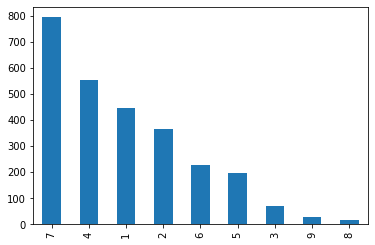

In [4]:
df_train['Class'].value_counts().plot(kind='bar')

<AxesSubplot:>

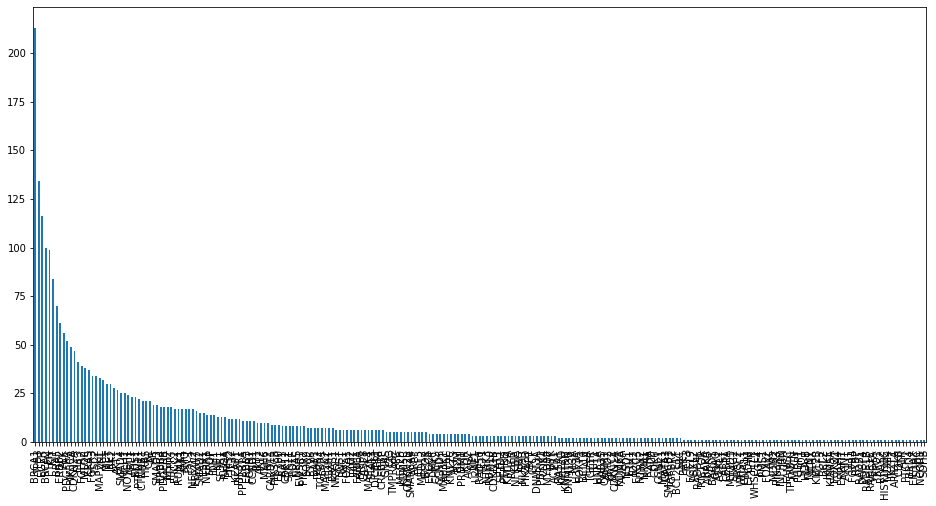

In [5]:
fig,ax = plt.subplots(figsize=(16,8))
df_train['Gene'].value_counts().plot(kind='bar',ax=ax)

In [6]:
# Any gene that appears less than 20 times mark them as rare
rareGenes = (df_train['Gene'].value_counts()[df_train['Gene'].value_counts() < 20]).index
notRareGenes = (df_train['Gene'].value_counts()[df_train['Gene'].value_counts() >= 20]).index

In [7]:
df_train['Variation'].value_counts()

Truncating Mutations    79
Amplification           62
Deletion                54
Fusions                 28
Overexpression           6
                        ..
H1966Y                   1
N659K                    1
R249S                    1
E946*                    1
Y418_D419del             1
Name: Variation, Length: 2442, dtype: int64

In [8]:
# Any variation that appears less than 20 times mark them as rare
rareVariation = (df_train['Variation'].value_counts()[df_train['Variation'].value_counts() < 20]).index
notRareVariation = (df_train['Variation'].value_counts()[df_train['Variation'].value_counts() >= 20]).index

In [9]:
df_train['Gene'] = np.where(df_train['Gene'].isin(rareGenes),'RARE',df_train['Gene'])

In [10]:
df_train['Variation'] = np.where(df_train['Variation'].isin(rareVariation),'RARE',df_train['Variation'])

In [11]:
df_train['Variation'].unique()

array(['Truncating Mutations', 'RARE', 'Deletion', 'Amplification',
       'Fusions'], dtype=object)

In [12]:
stop = list(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def clean_text(sentence):
    final_string = ''
    sentence = re.sub(f'[{re.escape(string.punctuation)}]','',' '.join(word_tokenize(sentence))).lower()
    sentence = ' '.join(word_tokenize(sentence))
    for word in sentence.split():
        #word = stemmer.stem(word)
        if word not in stop:
            final_string = final_string + word +' '
    return final_string.rstrip().lstrip()

In [13]:
df_train = df_train.sample(frac=1).reset_index(drop=True)

In [14]:
x_df_train = df_train[:1000].reset_index(drop=True)

In [15]:
%%time
x_df_train['TEXT'] = x_df_train['TEXT'].apply(clean_text)

CPU times: user 2min 56s, sys: 2.49 s, total: 2min 58s
Wall time: 2min 59s


In [16]:
x_df_train['kfold'] = -1

In [17]:
kf = StratifiedKFold(n_splits=5)

In [18]:
for fold,(t_,v_) in enumerate(kf.split(X = x_df_train[['Gene','Variation','TEXT']], y =x_df_train['Class'])):
    x_df_train.loc[v_,'kfold'] = fold

In [19]:
x_df_train['kfold'].value_counts()

4    200
3    200
2    200
1    200
0    200
Name: kfold, dtype: int64

In [20]:
x_df_train.head()

,Gene,Variation,Class,TEXT,kfold
0,KRAS,RARE,5,mutations ras proteins occur widely human canc...,0
1,BRCA2,RARE,6,mutation screening breast ovarian cancer–predi...,0
2,RARE,Deletion,1,eukaryotic cells dna packaged chromatin compac...,0
3,RARE,RARE,4,50 transitional cell carcinomas bladder show l...,0
4,RARE,RARE,4,cancer genome characterization efforts provide...,0


## USING BOW + NB 

In [116]:
for alpha in [0.0001,0.001,0.01,0.1,1,10,100,1000]:
    print(f'For Alpha = {alpha}')
    for fold in range(5):
        train = x_df_train[x_df_train['kfold']!=fold].reset_index(drop=True)
        y_train = train['Class']
        valid = x_df_train[x_df_train['kfold']==fold].reset_index(drop=True)
        y_valid = valid['Class']

        gene_count_vec = CountVectorizer()
        gene_count_vec.fit(train['Gene'])
        train_gene_ohe = gene_count_vec.transform(train['Gene'])

        variation_count_vec = CountVectorizer()
        variation_count_vec.fit(train['Variation'])
        train_variation_ohe = variation_count_vec.transform(train['Variation'])

        text_count_vec = CountVectorizer()
        text_count_vec.fit(train['TEXT'])
        train_text_ohe = text_count_vec.transform(train['TEXT'])

        x_train = hstack((train_gene_ohe,train_variation_ohe,train_text_ohe)).tocsr()

        valid_gene_ohe = gene_count_vec.transform(valid['Gene'])
        valid_variation_ohe = variation_count_vec.transform(valid['Variation'])
        valid_text_ohe = text_count_vec.transform(valid['TEXT'])

        x_valid = hstack((valid_gene_ohe,valid_variation_ohe,valid_text_ohe)).tocsr()

        NB = naive_bayes.MultinomialNB(alpha=alpha)
        NB.fit(x_train,y_train)

        preds = NB.predict_proba(x_valid)

        log_loss = metrics.log_loss(y_valid,preds,labels=NB.classes_)

        preds2 = NB.predict(x_valid)

        recall = metrics.recall_score(y_valid,preds2,average='micro')

        print(f'For fold = {fold}, Recall = {recall}, Log loss = {log_loss}')


For Alpha = 0.0001
For fold = 0, Recall = 0.545, Log loss = 15.715143259684371
For fold = 1, Recall = 0.55, Log loss = 15.28241020717834
For fold = 2, Recall = 0.515, Log loss = 16.55642204541462
For fold = 3, Recall = 0.57, Log loss = 14.851716947045496
For fold = 4, Recall = 0.545, Log loss = 15.543880677786106
For Alpha = 0.001
For fold = 0, Recall = 0.54, Log loss = 15.887837141658922
For fold = 1, Recall = 0.575, Log loss = 14.557123852874215
For fold = 2, Recall = 0.51, Log loss = 16.771759299841236
For fold = 3, Recall = 0.57, Log loss = 14.751186300857965
For fold = 4, Recall = 0.55, Log loss = 15.263223133781976
For Alpha = 0.01
For fold = 0, Recall = 0.54, Log loss = 15.887886002582993
For fold = 1, Recall = 0.565, Log loss = 14.764684508988362
For fold = 2, Recall = 0.505, Log loss = 16.83340527094954
For fold = 3, Recall = 0.555, Log loss = 15.191805426621118
For fold = 4, Recall = 0.54, Log loss = 15.62647434682971
For Alpha = 0.1
For fold = 0, Recall = 0.55, Log loss = 15

In [110]:
len(NB.feature_log_prob_[0])

115326

In [111]:
len(gene_count_vec.get_feature_names())

33

In [112]:
len(variation_count_vec.get_feature_names())

6

In [113]:
len(text_count_vec.get_feature_names())

115287

## USING TFIDF + NB 

In [117]:
type(x_df_train)

pandas.core.frame.DataFrame

In [118]:
x_df_train.head()

,Gene,Variation,Class,TEXT,kfold
0,KIT,RARE,2,context melanomas arising acral mucosal chroni...,0
1,RARE,RARE,2,describe fusion tp53bp1 pdgfrb patient chronic...,0
2,AKT1,RARE,8,serinethreonine protein kinase encoded akf pro...,0
3,RARE,RARE,1,increasing application gene panels familial ca...,0
4,TP53,RARE,1,many p53 missense mutations possess dominantne...,0


In [124]:
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

For alpha = 0.0001


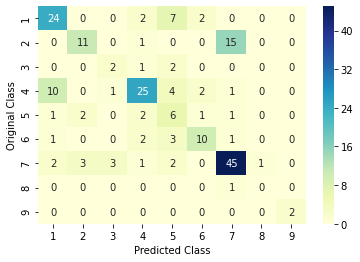

For fold = 0, Recall = 0.625, Log loss = 5.385155555941693


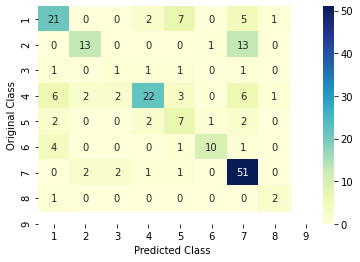

For fold = 1, Recall = 0.635, Log loss = 4.073790189072418


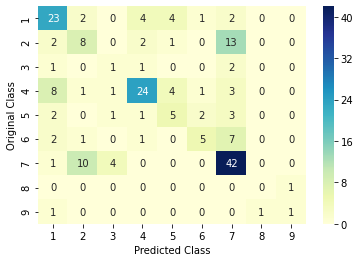

For fold = 2, Recall = 0.545, Log loss = 5.979254964936021


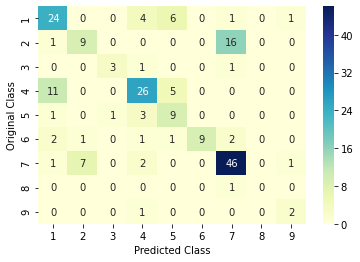

For fold = 3, Recall = 0.64, Log loss = 4.976491836909896


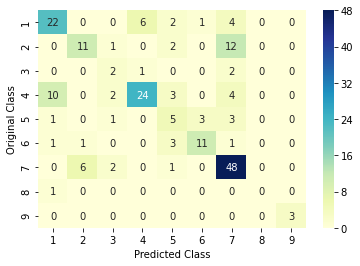

For fold = 4, Recall = 0.63, Log loss = 4.111205447604422
For alpha = 0.001


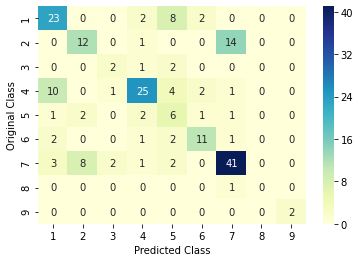

For fold = 0, Recall = 0.61, Log loss = 4.154371869928719


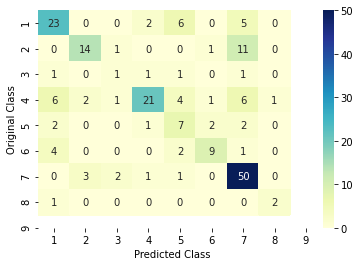

For fold = 1, Recall = 0.635, Log loss = 3.0813486188544776


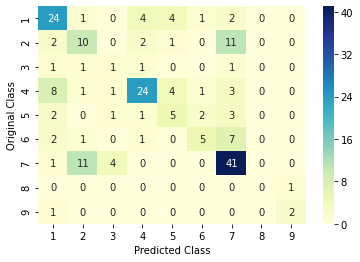

For fold = 2, Recall = 0.56, Log loss = 4.574320311107084


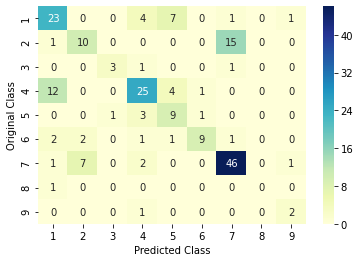

For fold = 3, Recall = 0.635, Log loss = 3.90117723827625


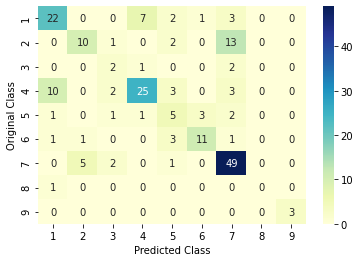

For fold = 4, Recall = 0.635, Log loss = 3.344694081207587
For alpha = 0.01


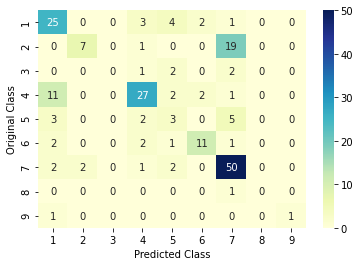

For fold = 0, Recall = 0.62, Log loss = 3.0307762903164126


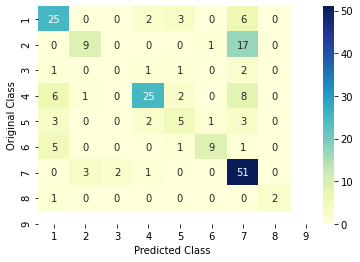

For fold = 1, Recall = 0.63, Log loss = 2.3665845161424874


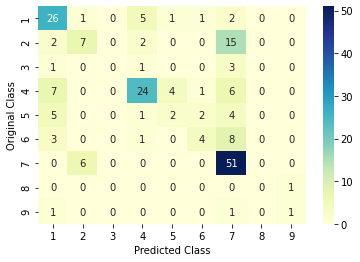

For fold = 2, Recall = 0.575, Log loss = 3.67318031815709


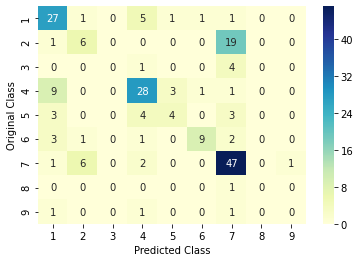

For fold = 3, Recall = 0.605, Log loss = 3.037933047417619


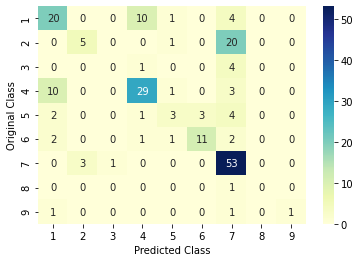

For fold = 4, Recall = 0.61, Log loss = 2.784990865612825
For alpha = 0.1


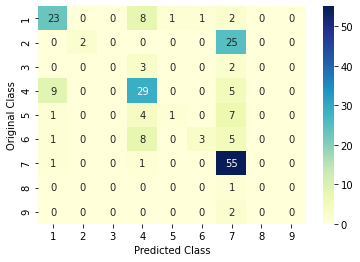

For fold = 0, Recall = 0.565, Log loss = 3.1870582609981954


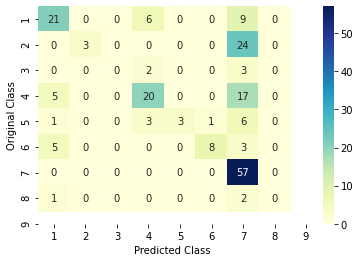

For fold = 1, Recall = 0.56, Log loss = 2.9765226221415992


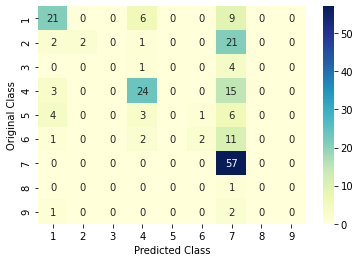

For fold = 2, Recall = 0.53, Log loss = 3.980760442109621


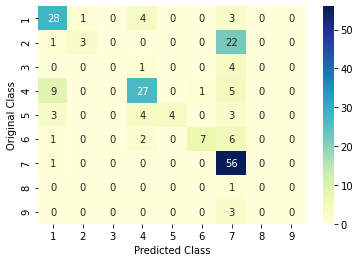

For fold = 3, Recall = 0.625, Log loss = 3.1401587766422083


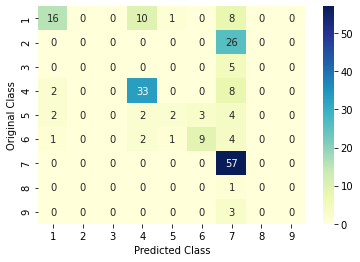

For fold = 4, Recall = 0.585, Log loss = 3.203367087736176
For alpha = 1


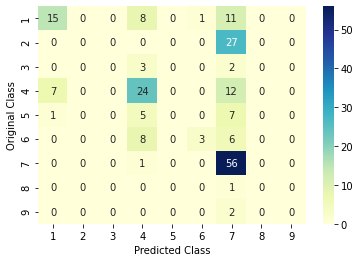

For fold = 0, Recall = 0.49, Log loss = 2.410634100299532


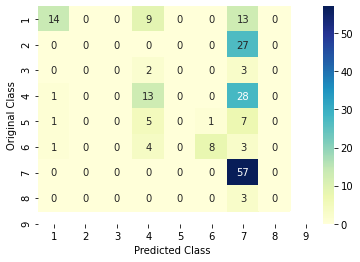

For fold = 1, Recall = 0.46, Log loss = 2.3722562353892975


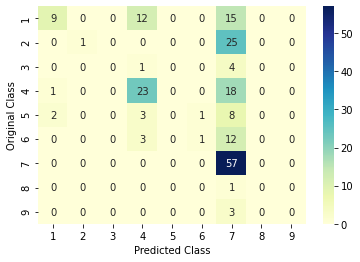

For fold = 2, Recall = 0.455, Log loss = 2.8194763413004758


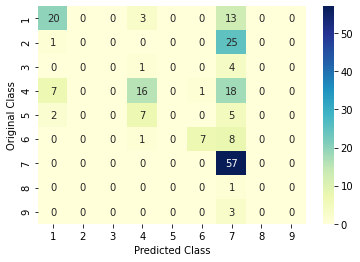

For fold = 3, Recall = 0.5, Log loss = 2.341014158448016


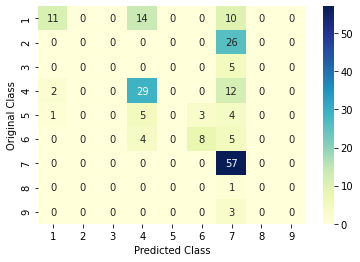

For fold = 4, Recall = 0.525, Log loss = 2.3495633983612936
For alpha = 10


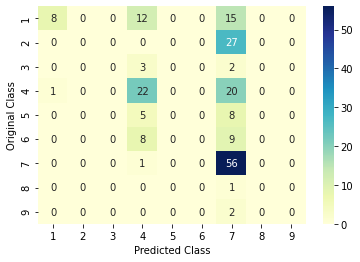

For fold = 0, Recall = 0.43, Log loss = 1.8107193590788944


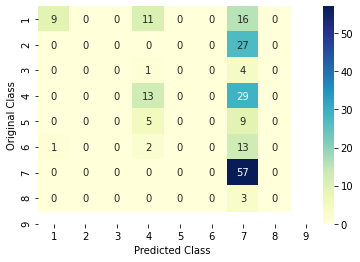

For fold = 1, Recall = 0.395, Log loss = 1.817763738730336


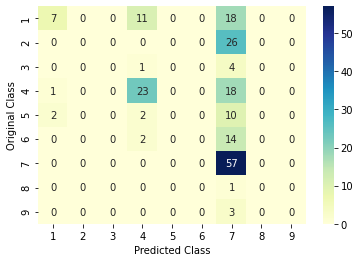

For fold = 2, Recall = 0.435, Log loss = 1.9371751290010695


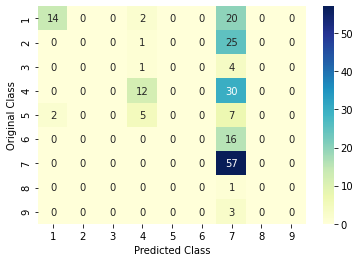

For fold = 3, Recall = 0.415, Log loss = 1.8074940818135519


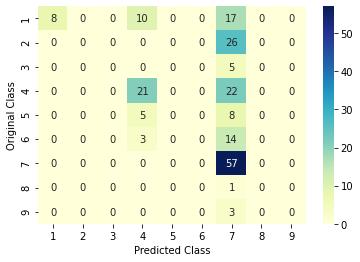

For fold = 4, Recall = 0.43, Log loss = 1.7849819371696785
For alpha = 100


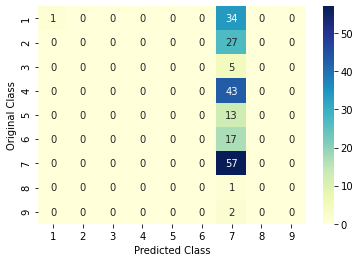

For fold = 0, Recall = 0.29, Log loss = 1.7895467358518897


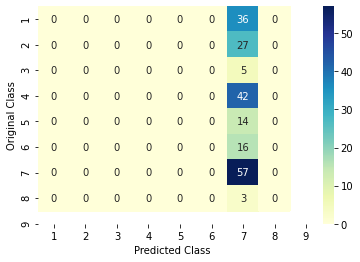

For fold = 1, Recall = 0.285, Log loss = 1.7924934592549107


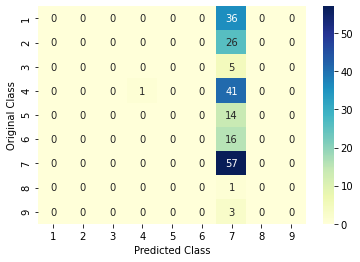

For fold = 2, Recall = 0.29, Log loss = 1.8289705093841275


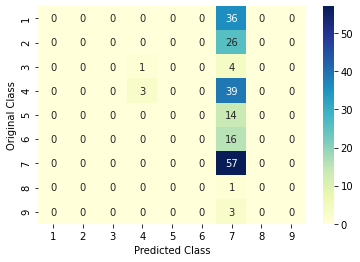

For fold = 3, Recall = 0.3, Log loss = 1.804139360934124


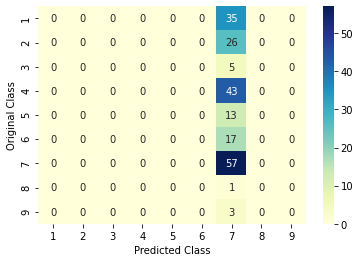

For fold = 4, Recall = 0.285, Log loss = 1.8045929704758352
For alpha = 1000


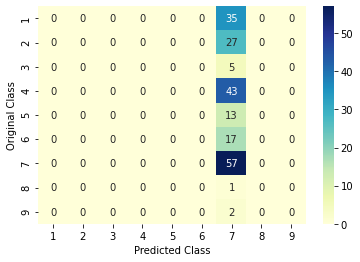

For fold = 0, Recall = 0.285, Log loss = 1.8072821845024936


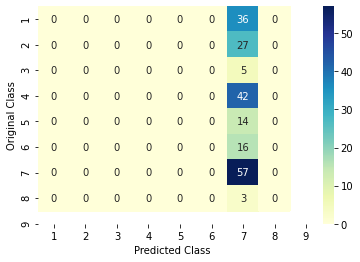

For fold = 1, Recall = 0.285, Log loss = 1.804075567072683


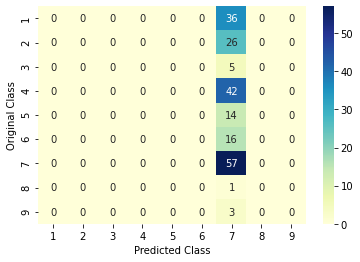

For fold = 2, Recall = 0.285, Log loss = 1.8232999026822367


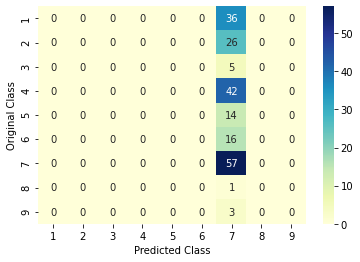

For fold = 3, Recall = 0.285, Log loss = 1.8205331678772039


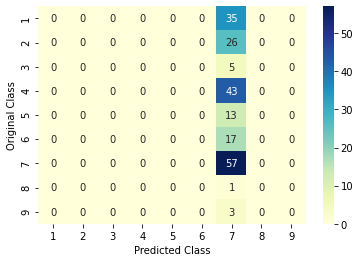

For fold = 4, Recall = 0.285, Log loss = 1.8197547040225752


In [125]:
for alpha in [0.0001,0.001,0.01,0.1,1,10,100,1000]:
    print(f'For alpha = {alpha}')
    for fold in range(5):
        train = x_df_train[x_df_train['kfold']!=fold].reset_index(drop=True)
        y_train = train['Class']
        valid = x_df_train[x_df_train['kfold']==fold].reset_index(drop=True)
        y_valid = valid['Class']

        gene_train_ohe_vect = CountVectorizer()
        gene_train_ohe_vect.fit(train['Gene'])
        gene_train_ohe = gene_train_ohe_vect.transform(train['Gene'])

        variation_train_ohe_vect = CountVectorizer()
        variation_train_ohe_vect.fit(train['Variation'])
        variation_train_ohe = variation_train_ohe_vect.transform(train['Variation'])

        text_train_tfidf_vect = TfidfVectorizer()
        text_train_tfidf_vect.fit(train['TEXT'])
        text_train_tfidf = text_train_tfidf_vect.transform(train['TEXT'])

        X_train = hstack((gene_train_ohe,variation_train_ohe,text_train_tfidf)).tocsr()

        NB = naive_bayes.MultinomialNB(alpha=alpha)
        NB.fit(X_train,y_train)

        valid_gene = gene_train_ohe_vect.transform(valid['Gene'])
        valid_variation = variation_train_ohe_vect.transform(valid['Variation'])
        valid_text = text_train_tfidf_vect.transform(valid['TEXT'])

        valid_X = hstack((valid_gene,valid_variation,valid_text)).tocsr()

        preds = NB.predict_proba(valid_X)

        log_loss = metrics.log_loss(y_valid,preds,labels=NB.classes_)

        preds2 = NB.predict(valid_X)

        recall = metrics.recall_score(y_valid,preds2,average='micro')
        
        cm = metrics.confusion_matrix(y_valid,preds2)
        sns.heatmap(cm,annot=True,cmap='YlGnBu',xticklabels=NB.classes_,yticklabels=NB.classes_)
        plt.xlabel('Predicted Class')
        plt.ylabel('Original Class')
        plt.show()
        
        print(f'For fold = {fold}, Recall = {recall}, Log loss = {log_loss}')


## USING TFIDF + LOG REG

In [128]:
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

In [129]:
for alpha in [0.0001,0.001,0.01,0.1,1,10,100,1000]:
    print(f'For alpha = {alpha}')
    for fold in range(5):
        train = x_df_train[x_df_train['kfold']!=fold].reset_index(drop=True)
        y_train = train['Class']
        valid = x_df_train[x_df_train['kfold']==fold].reset_index(drop=True)
        y_valid = valid['Class']

        gene_train_ohe_vect = CountVectorizer()
        gene_train_ohe_vect.fit(train['Gene'])
        gene_train_ohe = gene_train_ohe_vect.transform(train['Gene'])

        variation_train_ohe_vect = CountVectorizer()
        variation_train_ohe_vect.fit(train['Variation'])
        variation_train_ohe = variation_train_ohe_vect.transform(train['Variation'])

        text_train_tfidf_vect = TfidfVectorizer()
        text_train_tfidf_vect.fit(train['TEXT'])
        text_train_tfidf = text_train_tfidf_vect.transform(train['TEXT'])

        X_train = hstack((gene_train_ohe,variation_train_ohe,text_train_tfidf)).tocsr()

        NB = linear_model.LogisticRegression(C=alpha)
        NB.fit(X_train,y_train)

        valid_gene = gene_train_ohe_vect.transform(valid['Gene'])
        valid_variation = variation_train_ohe_vect.transform(valid['Variation'])
        valid_text = text_train_tfidf_vect.transform(valid['TEXT'])

        valid_X = hstack((valid_gene,valid_variation,valid_text)).tocsr()

        preds = NB.predict_proba(valid_X)

        log_loss = metrics.log_loss(y_valid,preds,labels=NB.classes_)

        preds2 = NB.predict(valid_X)

        recall = metrics.recall_score(y_valid,preds2,average='micro')
        
#         cm = metrics.confusion_matrix(y_valid,preds2)
#         sns.heatmap(cm,annot=True,cmap='YlGnBu',xticklabels=NB.classes_,yticklabels=NB.classes_)
#         plt.xlabel('Predicted Class')
#         plt.ylabel('Original Class')
#         plt.show()
        
        print(f'For fold = {fold}, Recall = {recall}, Log loss = {log_loss}')

For alpha = 0.0001
For fold = 0, Recall = 0.285, Log loss = 1.8158912381586922
For fold = 1, Recall = 0.285, Log loss = 1.8121288035450476
For fold = 2, Recall = 0.285, Log loss = 1.8286959401595697
For fold = 3, Recall = 0.285, Log loss = 1.8285812586597674
For fold = 4, Recall = 0.285, Log loss = 1.8266967185500413
For alpha = 0.001
For fold = 0, Recall = 0.285, Log loss = 1.806598493179636
For fold = 1, Recall = 0.285, Log loss = 1.8023720551315479
For fold = 2, Recall = 0.285, Log loss = 1.8202158537687887
For fold = 3, Recall = 0.285, Log loss = 1.8189807715129676
For fold = 4, Recall = 0.285, Log loss = 1.8160292143559646
For alpha = 0.01
For fold = 0, Recall = 0.37, Log loss = 1.7307058407030496
For fold = 1, Recall = 0.35, Log loss = 1.723574278581914
For fold = 2, Recall = 0.375, Log loss = 1.7518819943562076
For fold = 3, Recall = 0.34, Log loss = 1.7410820281394634
For fold = 4, Recall = 0.375, Log loss = 1.7277942640285744
For alpha = 0.1
For fold = 0, Recall = 0.545, Log l

## USING TDIDF + LOG REG + CLASS BALANCING (upsampling) 

In [130]:
for alpha in [0.0001,0.001,0.01,0.1,1,10,100,1000]:
    print(f'For alpha = {alpha}')
    for fold in range(5):
        train = x_df_train[x_df_train['kfold']!=fold].reset_index(drop=True)
        y_train = train['Class']
        valid = x_df_train[x_df_train['kfold']==fold].reset_index(drop=True)
        y_valid = valid['Class']

        gene_train_ohe_vect = CountVectorizer()
        gene_train_ohe_vect.fit(train['Gene'])
        gene_train_ohe = gene_train_ohe_vect.transform(train['Gene'])

        variation_train_ohe_vect = CountVectorizer()
        variation_train_ohe_vect.fit(train['Variation'])
        variation_train_ohe = variation_train_ohe_vect.transform(train['Variation'])

        text_train_tfidf_vect = TfidfVectorizer()
        text_train_tfidf_vect.fit(train['TEXT'])
        text_train_tfidf = text_train_tfidf_vect.transform(train['TEXT'])

        X_train = hstack((gene_train_ohe,variation_train_ohe,text_train_tfidf)).tocsr()

        NB = linear_model.LogisticRegression(C=alpha,class_weight='balanced')
        NB.fit(X_train,y_train)

        valid_gene = gene_train_ohe_vect.transform(valid['Gene'])
        valid_variation = variation_train_ohe_vect.transform(valid['Variation'])
        valid_text = text_train_tfidf_vect.transform(valid['TEXT'])

        valid_X = hstack((valid_gene,valid_variation,valid_text)).tocsr()

        preds = NB.predict_proba(valid_X)

        log_loss = metrics.log_loss(y_valid,preds,labels=NB.classes_)

        preds2 = NB.predict(valid_X)

        recall = metrics.recall_score(y_valid,preds2,average='micro')
        
#         cm = metrics.confusion_matrix(y_valid,preds2)
#         sns.heatmap(cm,annot=True,cmap='YlGnBu',xticklabels=NB.classes_,yticklabels=NB.classes_)
#         plt.xlabel('Predicted Class')
#         plt.ylabel('Original Class')
#         plt.show()
        
        print(f'For fold = {fold}, Recall = {recall}, Log loss = {log_loss}')

For alpha = 0.0001
For fold = 0, Recall = 0.3, Log loss = 2.1962901102552825
For fold = 1, Recall = 0.28, Log loss = 2.1962871068121426
For fold = 2, Recall = 0.25, Log loss = 2.1963613761228484
For fold = 3, Recall = 0.365, Log loss = 2.196193050113705
For fold = 4, Recall = 0.355, Log loss = 2.196111697118306
For alpha = 0.001
For fold = 0, Recall = 0.315, Log loss = 2.1880076226437613
For fold = 1, Recall = 0.285, Log loss = 2.187959971832305
For fold = 2, Recall = 0.25, Log loss = 2.188681320206992
For fold = 3, Recall = 0.365, Log loss = 2.1870347134388184
For fold = 4, Recall = 0.355, Log loss = 2.18621880362499
For alpha = 0.01
For fold = 0, Recall = 0.31, Log loss = 2.1161915719666506
For fold = 1, Recall = 0.305, Log loss = 2.1148318933279233
For fold = 2, Recall = 0.265, Log loss = 2.1201385721154637
For fold = 3, Recall = 0.38, Log loss = 2.1065600906959854
For fold = 4, Recall = 0.36, Log loss = 2.0987622546194786
For alpha = 0.1
For fold = 0, Recall = 0.325, Log loss = 1.8

## USING WORDTOVEC + LOG REG + CLASS Bal

In [135]:
import io

In [136]:
def load_vector(fname):
    fin = io.open(fname,'r',encoding='utf-8',newline='\n',errors='ignore')
    n,d = map(int,fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float,tokens[1:]))
    return data

In [137]:
def sentence_to_vec(s,embedding_dict):    
    M = []
    for w in s.split(' '):
        if w in embedding_dict:
            M.append(embedding_dict[w])
    
    if len(M)==0:
        return np.zeros(300)
    
    M = np.array(M)
    v = M.sum(axis=0)
    
    return v/(np.sqrt((v**2).sum()))

In [138]:
print('Loading Embeddings Start')
embeddings = load_vector("/Users/Anuj/Abhishek_Thakur_Book/Data/wiki-news-300d-1M.vec")
print('Loading Embeddings Done')

Loading Embeddings Start
Loading Embeddings Done


In [139]:
text_vectors = []
for review in x_df_train['TEXT']:
    text_vectors.append(sentence_to_vec(review,embeddings))

In [140]:
text_vectors = np.array(text_vectors)

In [141]:
y = x_df_train['Class']

In [156]:
for alpha in [0.0001,0.001,0.01,0.1,1,10,100,1000]:
    print(f'For alpha = {alpha}')
    for fold, (t_,v_) in enumerate(kf.split(X=text_vectors,y=y)):
        train_text = text_vectors[t_,:]
        train_y = y[t_]
        train_gene = x_df_train['Gene'][t_]
        train_variation = x_df_train['Variation'][t_]
        
        train_gene_vect = CountVectorizer()
        train_gene_vect.fit(train_gene)
        train_gene = train_gene_vect.transform(train_gene).toarray()
        
        train_variation_vect = CountVectorizer()
        train_variation_vect.fit(train_variation)
        train_variation = train_variation_vect.transform(train_variation).toarray()
        
        x_train = np.hstack((train_gene,train_variation,train_text))
        
        valid_text = text_vectors[v_,:]
        valid_y = y[v_]
        valid_gene = x_df_train['Gene'][v_]
        valid_variation = x_df_train['Variation'][v_]
        
        valid_gene = train_gene_vect.transform(valid_gene).toarray()
        valid_variation = train_variation_vect.transform(valid_variation).toarray()
        x_valid = np.hstack((valid_gene,valid_variation,valid_text))
        
        logres = linear_model.LogisticRegression(C=alpha,class_weight='balanced')
        logres.fit(x_train,train_y)
        
        preds = logres.predict_proba(x_valid)
        log_loss = metrics.log_loss(valid_y,preds,labels=logres.classes_)
        
        preds2 = logres.predict(x_valid)

        recall = metrics.recall_score(valid_y,preds2,average='micro')
        
#         cm = metrics.confusion_matrix(y_valid,preds2)
#         sns.heatmap(cm,annot=True,cmap='YlGnBu',xticklabels=NB.classes_,yticklabels=NB.classes_)
#         plt.xlabel('Predicted Class')
#         plt.ylabel('Original Class')
#         plt.show()
        
        print(f'For fold = {fold}, Recall = {recall}, Log loss = {log_loss}')
        


For alpha = 0.0001
For fold = 0, Recall = 0.16, Log loss = 2.196584175890876
For fold = 1, Recall = 0.24, Log loss = 2.1965759230483566
For fold = 2, Recall = 0.19, Log loss = 2.1966191343170913
For fold = 3, Recall = 0.285, Log loss = 2.1965000667743366
For fold = 4, Recall = 0.215, Log loss = 2.1964601337315814
For alpha = 0.001
For fold = 0, Recall = 0.16, Log loss = 2.190942908180548
For fold = 1, Recall = 0.25, Log loss = 2.1908428703886536
For fold = 2, Recall = 0.195, Log loss = 2.191260893618079
For fold = 3, Recall = 0.295, Log loss = 2.1900921922167473
For fold = 4, Recall = 0.215, Log loss = 2.189687457742135
For alpha = 0.01
For fold = 0, Recall = 0.25, Log loss = 2.1429728996245756
For fold = 1, Recall = 0.285, Log loss = 2.1410965641565234
For fold = 2, Recall = 0.225, Log loss = 2.1443624404567108
For fold = 3, Recall = 0.35, Log loss = 2.1343416050535193
For fold = 4, Recall = 0.345, Log loss = 2.130128020531663
For alpha = 0.1
For fold = 0, Recall = 0.285, Log loss = 1

## USING BOW + BIGRAM + LOG REG + CLASS BALANCING 

In [21]:
from sklearn import linear_model

In [23]:
for fold in range(5):
    train = x_df_train[x_df_train['kfold']!=fold].reset_index(drop=True)
    y_train = train['Class']
    valid = x_df_train[x_df_train['kfold']==fold].reset_index(drop=True)
    y_valid = valid['Class']
    
    train_gene_vect = CountVectorizer()
    train_gene_vect.fit(train['Gene'])
    train_gene = train_gene_vect.transform(train['Gene'])
    
    train_variation_vect = CountVectorizer()
    train_variation_vect.fit(train['Variation'])
    train_variation = train_variation_vect.transform(train['Variation'])
    
    train_text_vect = CountVectorizer(ngram_range=(1,2))
    train_text_vect.fit(train['TEXT'])
    train_text = train_text_vect.transform(train['TEXT'])
    
    x_train = hstack((train_gene,train_variation,train_text))
    
    valid_gene = train_gene_vect.transform(valid['Gene'])
    valid_variation = train_variation_vect.transform(valid['Variation'])
    valid_text = train_text_vect.transform(valid['TEXT'])
    
    x_valid = hstack((valid_gene,valid_variation,valid_text))
    
    logres = linear_model.LogisticRegression(class_weight='balanced')
    logres.fit(x_train,y_train)
    
    preds = logres.predict_proba(x_valid)
    
    log_loss = metrics.log_loss(y_valid,preds,labels=logres.classes_)
    
    preds2 = logres.predict(x_valid)
    
    recall = metrics.recall_score(y_valid,preds2,average='micro')
    
    print(f'For Fold = {fold}, recall = {recall}, logloss = {log_loss}')

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


For Fold = 0, recall = 0.535, logloss = 8.588553724212499


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


For Fold = 1, recall = 0.535, logloss = 6.848463614466616


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


For Fold = 2, recall = 0.625, logloss = 5.808876031634677


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


For Fold = 3, recall = 0.505, logloss = 8.586864597188168


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


For Fold = 4, recall = 0.535, logloss = 8.034014547199925


## USING BOW without bigram + Random Forest + class balancing

In [24]:
from sklearn import ensemble

In [25]:
for fold in range(5):
    train = x_df_train[x_df_train['kfold']!=fold].reset_index(drop=True)
    y_train = train['Class']
    valid = x_df_train[x_df_train['kfold']==fold].reset_index(drop=True)
    y_valid = valid['Class']
    
    train_gene_vect = CountVectorizer()
    train_gene_vect.fit(train['Gene'])
    train_gene = train_gene_vect.transform(train['Gene'])
    
    train_variation_vect = CountVectorizer()
    train_variation_vect.fit(train['Variation'])
    train_variation = train_variation_vect.transform(train['Variation'])
    
    train_text_vect = CountVectorizer()
    train_text_vect.fit(train['TEXT'])
    train_text = train_text_vect.transform(train['TEXT'])
    
    x_train = hstack((train_gene,train_variation,train_text))
    
    valid_gene = train_gene_vect.transform(valid['Gene'])
    valid_variation = train_variation_vect.transform(valid['Variation'])
    valid_text = train_text_vect.transform(valid['TEXT'])
    
    x_valid = hstack((valid_gene,valid_variation,valid_text))
    
    rf = ensemble.RandomForestClassifier(class_weight='balanced')
    rf.fit(x_train,y_train)
    
    preds = rf.predict_proba(x_valid)
    
    log_loss = metrics.log_loss(y_valid,preds,labels=logres.classes_)
    
    preds2 = rf.predict(x_valid)
    
    recall = metrics.recall_score(y_valid,preds2,average='micro')
    
    print(f'For Fold = {fold}, recall = {recall}, logloss = {log_loss}')

For Fold = 0, recall = 0.57, logloss = 2.0506130031333543
For Fold = 1, recall = 0.55, logloss = 2.4940898973945287
For Fold = 2, recall = 0.625, logloss = 1.6867902229022045
For Fold = 3, recall = 0.52, logloss = 1.975433140332222
For Fold = 4, recall = 0.575, logloss = 2.003240095808218


## ## USING TFIDF + Random Forest + class balancing 

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
for fold in range(5):
    train = x_df_train[x_df_train['kfold']!=fold].reset_index(drop=True)
    y_train = train['Class']
    valid = x_df_train[x_df_train['kfold']==fold].reset_index(drop=True)
    y_valid = valid['Class']
    
    train_gene_vect = CountVectorizer()
    train_gene_vect.fit(train['Gene'])
    train_gene = train_gene_vect.transform(train['Gene'])
    
    train_variation_vect = CountVectorizer()
    train_variation_vect.fit(train['Variation'])
    train_variation = train_variation_vect.transform(train['Variation'])
    
    train_text_vect = TfidfVectorizer()
    train_text_vect.fit(train['TEXT'])
    train_text = train_text_vect.transform(train['TEXT'])
    
    x_train = hstack((train_gene,train_variation,train_text))
    
    valid_gene = train_gene_vect.transform(valid['Gene'])
    valid_variation = train_variation_vect.transform(valid['Variation'])
    valid_text = train_text_vect.transform(valid['TEXT'])
    
    x_valid = hstack((valid_gene,valid_variation,valid_text))
    
    rf = ensemble.RandomForestClassifier(class_weight='balanced')
    rf.fit(x_train,y_train)
    
    preds = rf.predict_proba(x_valid)
    
    log_loss = metrics.log_loss(y_valid,preds,labels=logres.classes_)
    
    preds2 = rf.predict(x_valid)
    
    recall = metrics.recall_score(y_valid,preds2,average='micro')
    
    print(f'For Fold = {fold}, recall = {recall}, logloss = {log_loss}')

For Fold = 0, recall = 0.52, logloss = 2.199869641419697
For Fold = 1, recall = 0.57, logloss = 1.8840446296597193
For Fold = 2, recall = 0.66, logloss = 1.3589747684629527
For Fold = 3, recall = 0.525, logloss = 1.9182455360886166
For Fold = 4, recall = 0.59, logloss = 1.8543546323132716


## USE BOW + STANDARD SCALER + LOG RES + CLASS BALANCING 

In [29]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

In [32]:
for fold in range(5):
    train = x_df_train[x_df_train['kfold']!=fold].reset_index(drop=True)
    y_train = train['Class']
    valid = x_df_train[x_df_train['kfold']==fold].reset_index(drop=True)
    y_valid = valid['Class']
    
    train_gene_vect = CountVectorizer()
    train_gene_vect.fit(train['Gene'])
    train_gene = train_gene_vect.transform(train['Gene'])
    scaler_gene = StandardScaler(with_mean=False)
    scaler_gene.fit(train_gene)
    train_gene = scaler_gene.transform(train_gene)
    
    train_variation_vect = CountVectorizer()
    train_variation_vect.fit(train['Variation'])
    train_variation = train_variation_vect.transform(train['Variation'])
    scaler_variation = StandardScaler(with_mean=False)
    scaler_variation.fit(train_variation)
    train_variation = scaler_variation.transform(train_variation)
    
    train_text_vect = CountVectorizer(ngram_range=(1,2))
    train_text_vect.fit(train['TEXT'])
    train_text = train_text_vect.transform(train['TEXT'])
    scaler_text = StandardScaler(with_mean=False)
    scaler_text.fit(train_text)
    train_text = scaler_text.transform(train_text)
    
    x_train = hstack((train_gene,train_variation,train_text))
    
    valid_gene = train_gene_vect.transform(valid['Gene'])
    valid_gene = scaler_gene.transform(valid_gene)
    valid_variation = train_variation_vect.transform(valid['Variation'])
    valid_variation = scaler_variation.transform(valid_variation)
    valid_text = train_text_vect.transform(valid['TEXT'])
    valid_text = scaler_text.transform(valid_text)
    
    x_valid = hstack((valid_gene,valid_variation,valid_text))
    
    logres = linear_model.LogisticRegression(class_weight='balanced')
    logres.fit(x_train,y_train)
    
    preds = logres.predict_proba(x_valid)
    
    log_loss = metrics.log_loss(y_valid,preds,labels=logres.classes_)
    
    preds2 = logres.predict(x_valid)
    
    recall = metrics.recall_score(y_valid,preds2,average='micro')
    
    print(f'For Fold = {fold}, recall = {recall}, logloss = {log_loss}')

For Fold = 0, recall = 0.495, logloss = 8.868284372221535
For Fold = 1, recall = 0.545, logloss = 8.131556446739392
For Fold = 2, recall = 0.62, logloss = 7.327958255536845
For Fold = 3, recall = 0.485, logloss = 8.871734198686879
For Fold = 4, recall = 0.525, logloss = 6.950503484094031


From here we can get the most important feature of each class

In [36]:
logres.coef_.shape

(9, 1478863)

In [40]:
len(train_text_vect.get_feature_names()) + len(train_variation_vect.get_feature_names()) + len(train_gene_vect.get_feature_names())

1478863